In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import py4DSTEM
from scipy import ndimage
import gc

import time
import sys
sys.path.append('../XTEC/src/xtec')

from Preprocessing import Mask_Zeros
from Preprocessing import Threshold_Background
from GMM import GMM
import re

import h5py

## Loading

In [3]:
workingdir='../STEM_recal/'
# workingdir='/home/shared/STEM_recal/'

In [4]:
f=h5py.File(workingdir+'data.hdf5','r')

In [5]:
I,T=f['I'],f['T']

## Animation

In [6]:
from matplotlib.animation import FuncAnimation

Text(0.5, 1.0, '$\\bar{I}$')

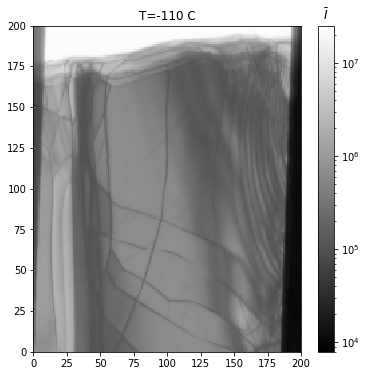

In [10]:
data=I[0,:,:,44:65,44:65].mean(axis=(2,3))
fig,ax=plt.subplots(figsize=(6,6))
im=ax.pcolormesh(data,cmap='gray', norm=colors.LogNorm(vmin=10**3.9, vmax=10**7.4))
tit=ax.set_title('T={:d} C'.format(T[0]))
cb=plt.colorbar(im)
cb.ax.set_title(r'$\bar{I}$')

# ax.plot([x],[y],'.r')

In [11]:
from IPython import display

In [ ]:
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()    

In [83]:
def animate(i):
    data=I[i,:,:,44:65,44:65].mean(axis=(-2,-1))
    im.set_array(data.ravel())
    tit.set_text('T={:d} C'.format(T[i]))
    return im,tit

In [70]:
anim = FuncAnimation(fig, animate, interval=1000, frames=T.shape[0],blit=True,repeat=True)
anim.save('I_ave.mp4',dpi=600)

In [539]:
def find_threshold_rel(data,err=.5,mask_target=None,min_distance=3):
    '''
    data should be rescaled by log10
    binary search the steepest point
    '''

    thres_=np.array([0,1.])  # min,max
    if mask_target is None:
        mask_target=np.array([peak_local_max(np.log10(data),threshold_rel=thres).shape[0] for thres in thres_]).mean()
    thres_middle=thres_.mean()
    mask_middle=peak_local_max(np.log10(data),threshold_rel=thres_middle,min_distance=3)
    while np.abs(mask_target-mask_middle.shape[0])>err:
        if mask_middle.shape[0]>mask_target:
            thres_[0]=thres_middle
        else:
            thres_[1]=thres_middle
        thres_middle=thres_.mean()
        mask_middle=peak_local_max(np.log10(data),threshold_rel=thres_middle,min_distance=3)
    return thres_middle,mask_middle,mask_target,


In [540]:
# x,y=75,125
x,y=100,100
T_idx=0
data=I[T_idx,x,y,:,:]


## interpolate (blur the image)

In [177]:
from scipy import interpolate


In [184]:
xmesh,ymesh=np.meshgrid(np.linspace(0,data.shape[0]-1,data.shape[0]),np.linspace(0,data.shape[1]-1,data.shape[1]))

In [ ]:
f = interpolate.interp2d(xmesh, ymesh, np.log10(data), kind='cubic')

In [ ]:
xline_fine,yline_fine=np.linspace(0,data.shape[0]-1,data.shape[0]*5),np.linspace(0,data.shape[0]-1,data.shape[0]*5)

In [ ]:
zmesh_line=f(xline_fine,yline_fine)

Text(0.5, 1.0, 'I')

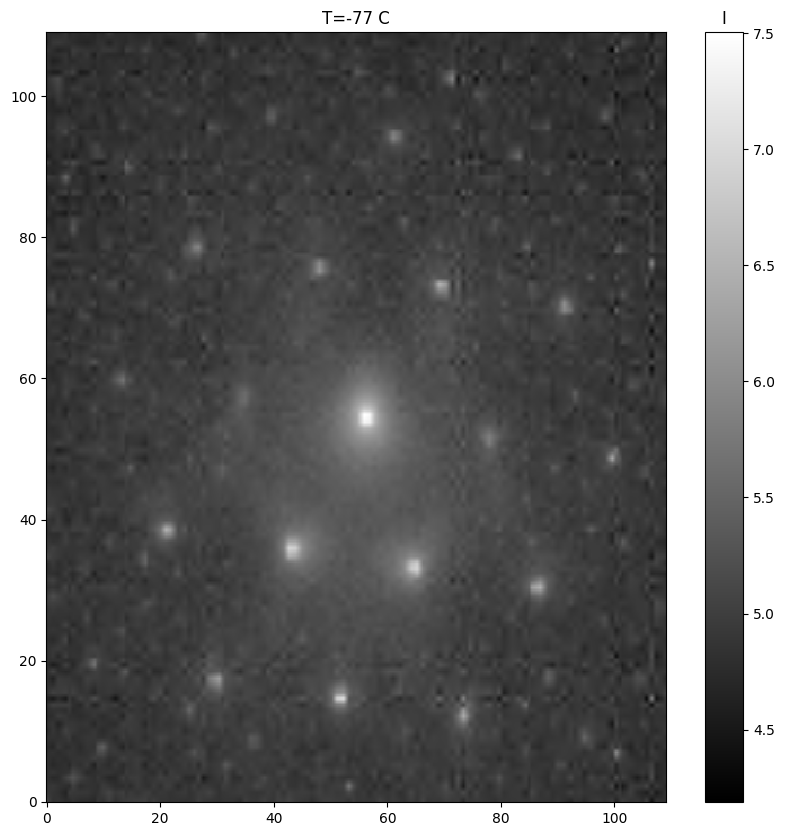

In [208]:
fig,ax=plt.subplots(figsize=(10,10))


im=ax.pcolormesh(xline_fine,yline_fine,zmesh_line,cmap='gray')
tit=ax.set_title('T={:d} C'.format(T[T_idx]))
cb=plt.colorbar(im)
cb.ax.set_title('I')
# ax.scatter(55,55)

# ax.scatter(mask[:,1]+0.5,mask[:,0]+0.5,s=5,c='r')


## find peaks and visualize

In [541]:
data.shape

(110, 110)

In [611]:
# thres,mask_ind,_=find_threshold_rel(data,min_distance=1)
mask_ind=peak_local_max(np.log10(data),threshold_rel=0,min_distance=3)
data_masked=data[tuple(mask_ind.T)]

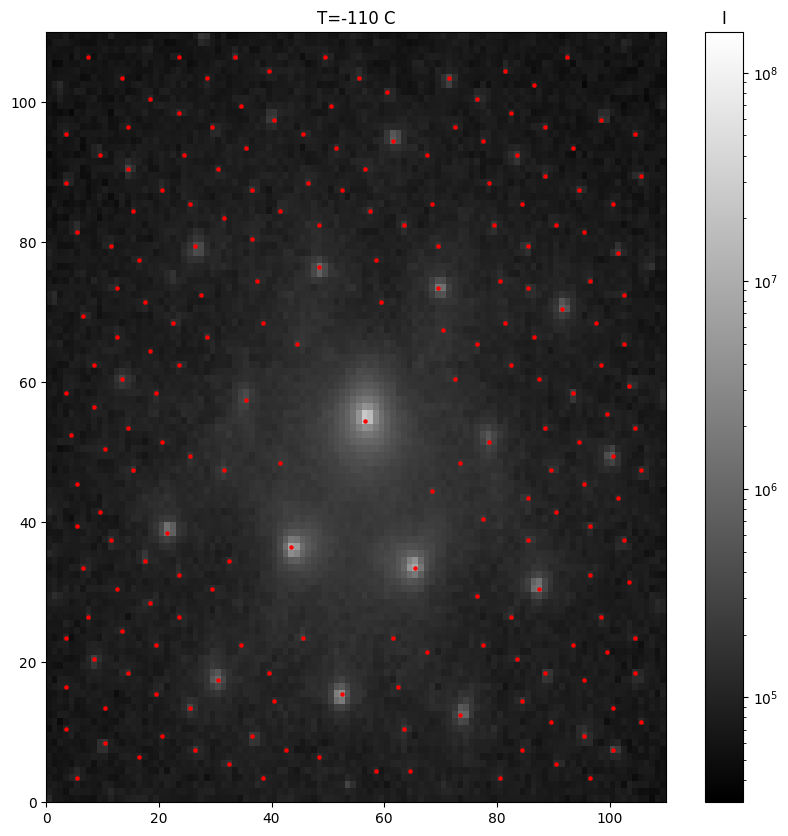

In [613]:
fig,ax=plt.subplots(figsize=(10,10))


vmin,vmax=I[:,x,y].min(),I[:,x,y].max()
im=ax.pcolormesh(data,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
tit=ax.set_title('T={:d} C'.format(T[T_idx]))
cb=plt.colorbar(im)
cb.ax.set_title('I')
# ax.scatter(55,55)

# ax.scatter(mask_ind[:,1]+0.5,mask_ind[:,0]+0.5,s=5,c='r')
ax.scatter(mask_ind[:,1]+.5,mask_ind[:,0]+.5,s=5,c='r')

In [614]:
center_list=[find_threshold_rel(data=I[T_idx,x,y,45:65,45:65],err=0,mask_target=1)[1] for T_idx in range(T.shape[0]-1)]

In [615]:
offset_list=[center-center_list[0] for center in center_list]

## shift and track

In [622]:
mask_ind_shift=[mask_ind+offset for offset in offset_list]

In [623]:
Data_ind=mask_ind_shift[0]
Data_thresh=np.log10(np.array([I[T_ind,x,y][tuple(ind.T)] for T_ind,ind in zip(range(T.shape[0]-1),mask_ind_shift)]))
# Data_thresh=(np.log10(np.array([I[T_ind,x,y][tuple(ind.T)] for T_ind,ind in zip(range(T.shape[0]-1),mask_ind_shift)]))+np.log10(np.array([I[T_ind,x+1,y][tuple(ind.T)] for T_ind,ind in zip(range(T.shape[0]-1),mask_ind_shift)]))+np.log10(np.array([I[T_ind,x-1,y][tuple(ind.T)] for T_ind,ind in zip(range(T.shape[0]-1),mask_ind_shift)]))+np.log10(np.array([I[T_ind,x,y+1][tuple(ind.T)] for T_ind,ind in zip(range(T.shape[0]-1),mask_ind_shift)]))+np.log10(np.array([I[T_ind,x,y-1][tuple(ind.T)] for T_ind,ind in zip(range(T.shape[0]-1),mask_ind_shift)])))/5

In [618]:
Data_ind.shape

(209, 2)

In [565]:
Data_thresh.shape

(17, 183)

## Test, and normalize to Gaussian

(array([  26.,  541., 2575., 2814.,  844.,  150.,   56.,   42.,   37.,
          23.,   26.,   21.,   21.,   10.,    6.,   11.,    7.,    6.,
           4.,    5.]),
 array([4.604448 , 4.753445 , 4.9024425, 5.05144  , 5.2004366, 5.349434 ,
        5.498431 , 5.6474285, 5.796426 , 5.945423 , 6.0944204, 6.2434173,
        6.3924146, 6.541412 , 6.690409 , 6.8394065, 6.988404 , 7.1374006,
        7.286398 , 7.4353952, 7.5843925], dtype=float32),
 <BarContainer object of 20 artists>)

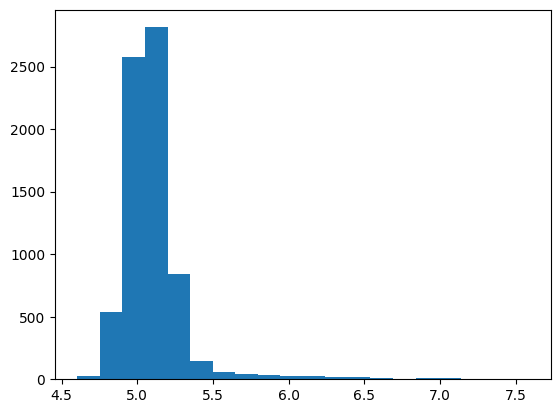

In [457]:
plt.hist(Data_thresh.flatten(),bins=20)

In [401]:
data_post_thresh = Data_thresh
Rescaled_data = (data_post_thresh-np.mean(data_post_thresh,axis=0))/np.std(np.mean(data_post_thresh,axis=0)) 


(array([7.000e+00, 3.000e+00, 1.100e+01, 1.900e+01, 4.700e+01, 2.630e+02,
        1.689e+03, 3.176e+03, 1.496e+03, 3.610e+02, 9.400e+01, 3.200e+01,
        1.200e+01, 5.000e+00, 5.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([-3.4693928 , -3.0092194 , -2.549046  , -2.088873  , -1.6286995 ,
        -1.1685262 , -0.70835286, -0.24817953,  0.21199378,  0.6721671 ,
         1.1323404 ,  1.5925138 ,  2.0526872 ,  2.5128603 ,  2.9730337 ,
         3.433207  ,  3.8933804 ,  4.353554  ,  4.813727  ,  5.2739005 ,
         5.7340736 ], dtype=float32),
 <BarContainer object of 20 artists>)

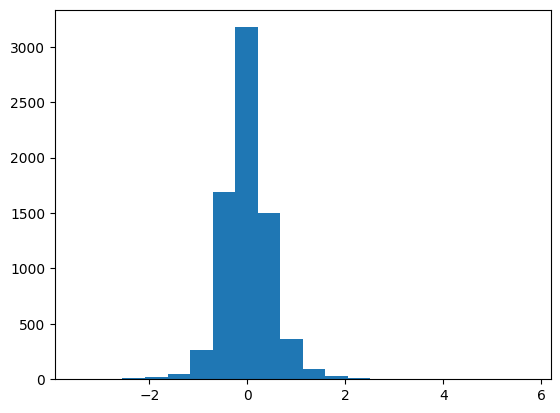

In [402]:
plt.hist(Rescaled_data.flatten(),bins=20)

In [404]:
import scipy

In [407]:
scipy.stats.kurtosistest(Rescaled_data.flatten())

KurtosistestResult(statistic=35.05663517451123, pvalue=3.0894307152643595e-269)

In [415]:
z=np.random.normal(size=(10000,))

In [416]:
scipy.stats.kurtosistest(z)

KurtosistestResult(statistic=-0.8381824990862147, pvalue=0.4019282145123986)

## Clustering

In [624]:
Tlist=T[:-1]
x_train = np.array(Tlist)
data_post_thresh = Data_thresh
# Rescaled_data= data_post_thresh
# Rescaled_data  = (data_post_thresh/np.mean(data_post_thresh,axis=0)-1) 
Rescaled_data = (data_post_thresh-np.mean(data_post_thresh,axis=0))/np.std(np.mean(data_post_thresh,axis=0))

y_train=Rescaled_data.transpose() 
print('Data shape: (num_data, num_T)=',y_train.shape)

Data shape: (num_data, num_T)= (209, 17)


Num per cluster [36, 173]


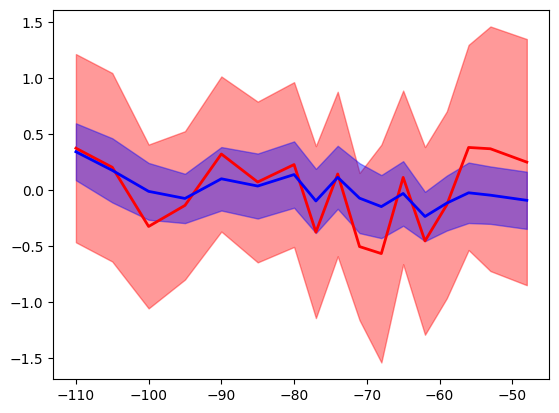

In [625]:
num_clusters = 2
clusterGMM = GMM(y_train,num_clusters)
clusterGMM.RunEM()
print('Num per cluster',clusterGMM.num_per_cluster)
cluster_assignments = clusterGMM.cluster_assignments
clusterGMM.Plot_Cluster_Results_traj(x_train)

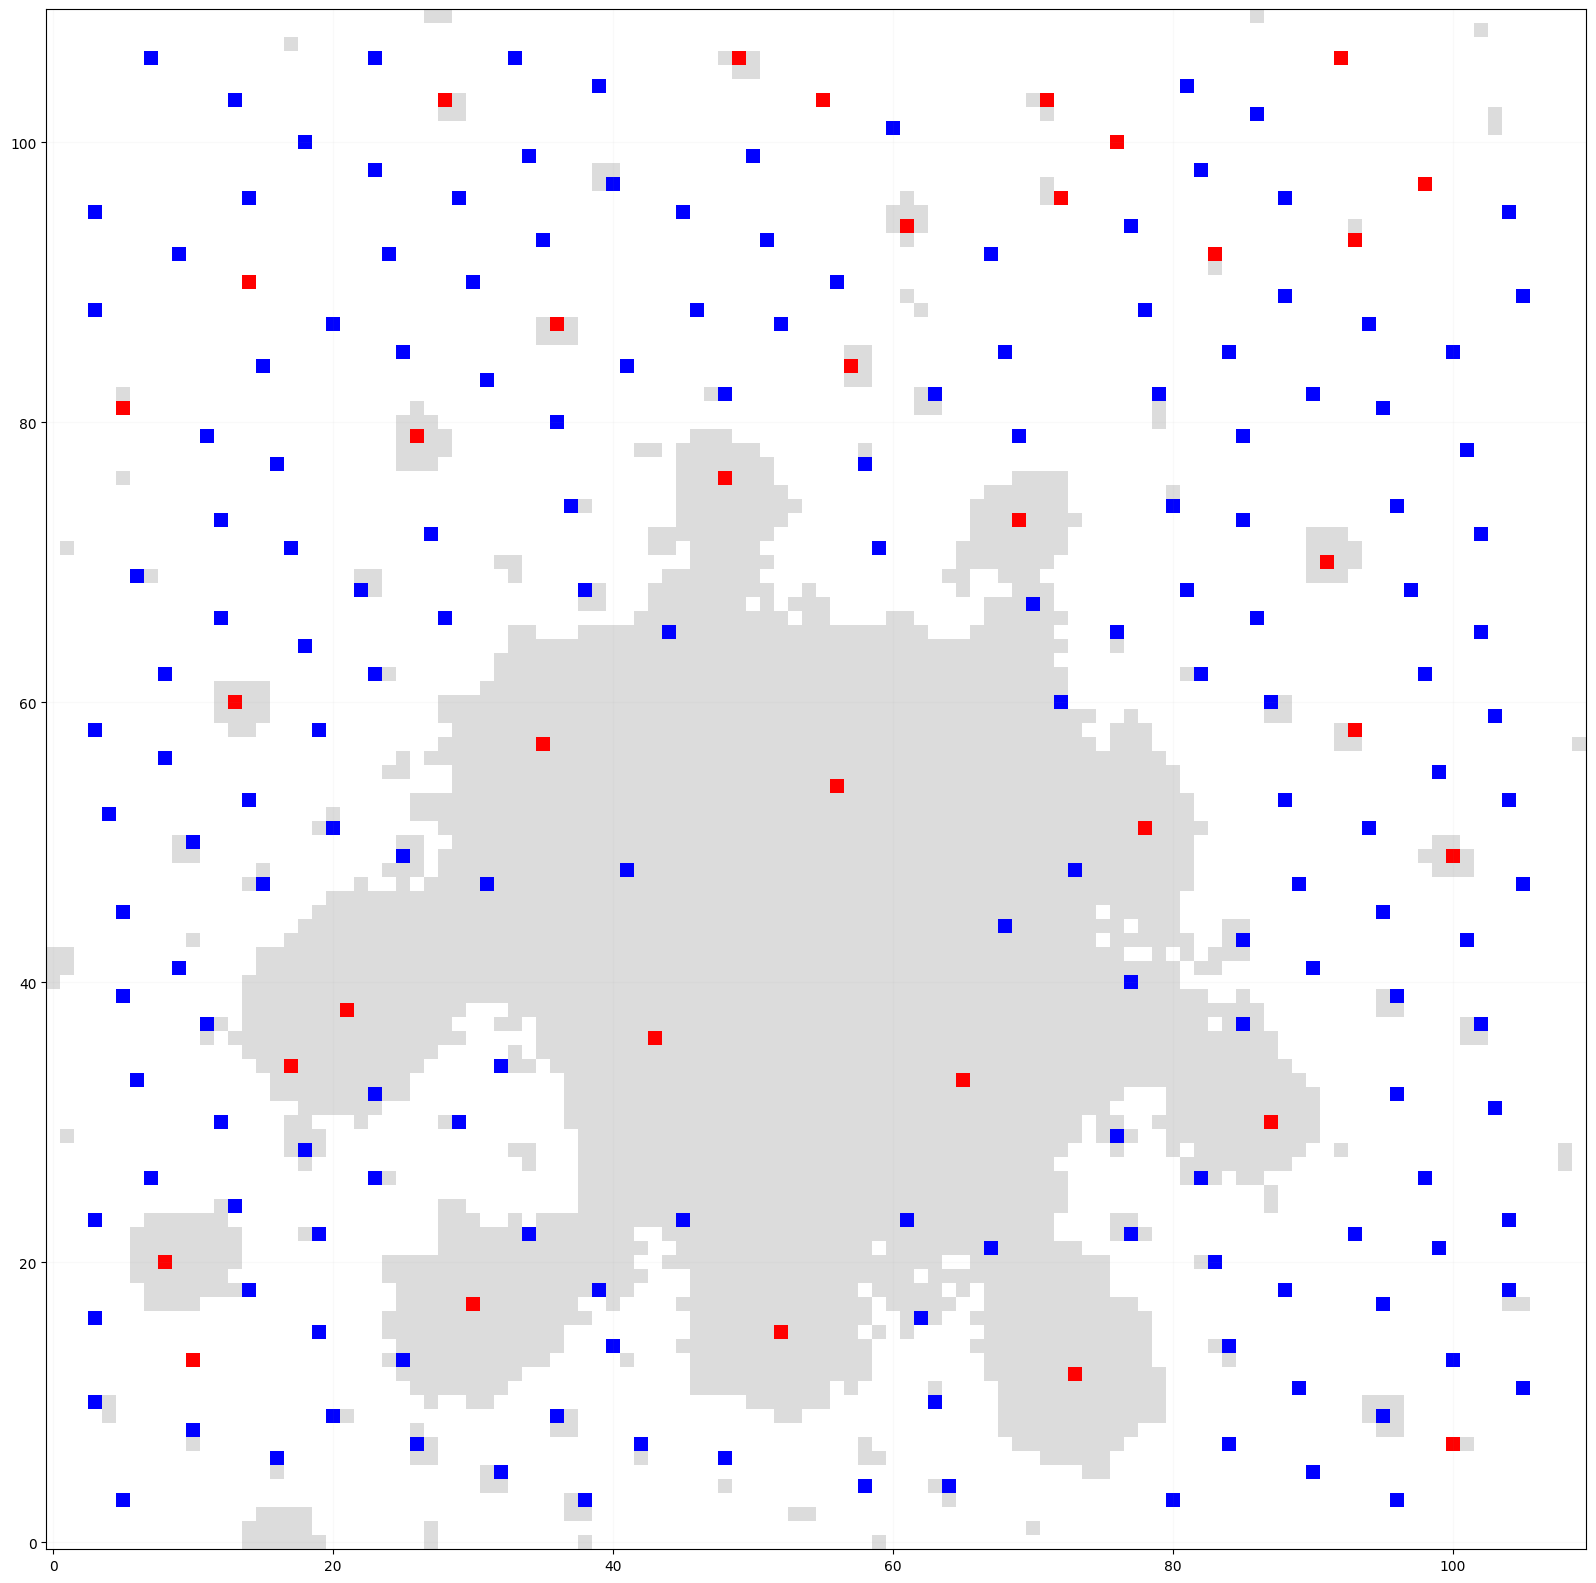

In [626]:
plotting_slice = threshold.thresholded.copy()
for k in range(num_clusters):
    cluster_mask = clusterGMM.cluster_assignments == k
    cluster_ind = Data_ind[cluster_mask]
    plotting_slice[cluster_ind[:, 0], cluster_ind[:, 1]] = k + 2
color_list = ['white', 'gainsboro', 'red', 'blue', 'green', 'purple', 'yellow', 'orange', 'pink']
cluster_cmap = colors.ListedColormap(color_list)
    
bounds = []
for i in range(len(color_list)+1):
    bounds.append(i-0.5)
norm = colors.BoundaryNorm(bounds,cluster_cmap.N)
fig=plt.figure(figsize=(20,20))


plt.imshow(plotting_slice,origin='lower',cmap=cluster_cmap,norm=norm)
plt.grid(color='#999999', linestyle='-', alpha=0.05)

## Sweep thresdhold

In [588]:
thres_list=np.linspace(0.4,.99,21)

In [620]:
mask_ind=peak_local_max(np.log10(data),threshold_rel=0,min_distance=3)

In [621]:
mask_ind.shape

(209, 2)

In [599]:
mask_list=[peak_local_max(np.log10(data),indices=False,threshold_rel=thres,min_distance=1) for thres in thres_list]

/tmp/ipykernel_724/2933098516.py:1: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  mask_list=[peak_local_max(np.log10(data),indices=False,threshold_rel=thres,min_distance=1) for thres in thres_list]


In [600]:
porp=[m.sum()/np.prod(data.shape) for m in mask_list]

In [601]:
thres_list[np.abs(porp-porp[0]/2).argmin()]

0.6950000000000001

In [ ]:
plt.plot(thres_list,porp)

In [18]:
from skimage.feature import peak_local_max

In [81]:
mask=peak_local_max(data,indices=False)

In [64]:
idx[0]

array([54, 56])

In [65]:
data[54,56]

25149210.0

In [67]:
data[tuple(idx[0])]

25149210.0

In [69]:
data_peak=[data[tuple(ind)] for ind in idx]

Text(0.5, 1.0, 'I')

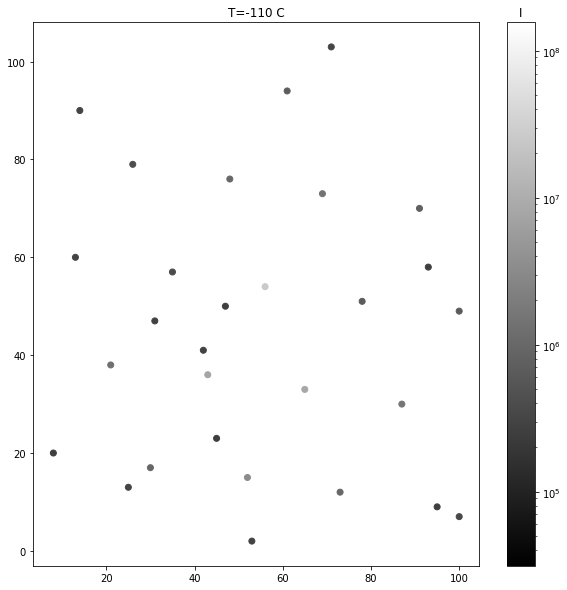

In [96]:
fig,ax=plt.subplots(figsize=(10,10))
T_idx=0
# vmin,vmax=I[:,x,y].min(),I[:,x,y].max()
im=ax.scatter(xmesh_masked,ymesh_masked,c=data_masked,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
# im=ax.scatter(idx[:,1],idx[:,0],c=data_peak,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
# im=ax.tripcolor(xmesh_masked,ymesh_masked,data_masked,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
tit=ax.set_title('T={:d} C'.format(T[T_idx]))
cb=plt.colorbar(im)
cb.ax.set_title('I')
# ax.scatter(55,55)


In [66]:
def animate(i):
    data=I[i,x,y,:,:]
    im.set_array(data.ravel())
    tit.set_text('T={:d} C'.format(T[i]))
    return im,tit

In [67]:
anim = FuncAnimation(fig, animate, interval=1000, frames=T.shape[0],blit=True,repeat=True)
anim.save('movie.mp4',dpi=300)

# get threshold

In [11]:
from scipy import signal
from scipy import misc

In [246]:
x,y=100,100
I_pos=I[:-1,x,y,:,:]

In [251]:
I_pos.shape

(17, 110, 110)

In [60]:
I_pos[[0]].min()

40827.773

In [249]:
masked    = Mask_Zeros(I_pos) 
threshold = Threshold_Background(masked)
Thresh_cutoff=threshold.LogI_cutoff


In [252]:
masked.zero_mask.sum()

0

In [253]:
threshold.LogI_cutoff

11.700895

In [50]:
print('num of original data pixels=', np.prod(I.shape[1:])) 
print('num of thresholded data pixels=', threshold.data_thresholded.shape[1])
print('cutoff=', Thresh_cutoff)

num of original data pixels= 484000000
num of thresholded data pixels= 2190
cutoff= 11.864941


In [254]:
Data_thresh     = threshold.data_thresholded  # shape=(num_temperatures, num_thresholded data)
Data_ind        = threshold.ind_thresholded           # contains hkl indices of the thresholded data.

In [256]:
Data_thresh

array([[  91339.42 ,   96530.35 ,  100697.16 , ...,  194865.23 ,
         154615.56 ,   81979.45 ],
       [  85089.195,   97614.516,  105650.   , ...,  117130.29 ,
         100223.27 ,   74275.375],
       [  97246.414,  131028.7  ,  154692.89 , ...,  105179.016,
          81426.125,   86950.24 ],
       ...,
       [ 280641.34 ,  490103.97 ,  977283.5  , ...,  120565.64 ,
         122599.1  ,  226249.38 ],
       [ 333174.2  ,  666579.25 , 1054237.6  , ...,  186760.61 ,
          95927.94 ,  360592.53 ],
       [ 241396.2  ,  428187.1  ,  717372.   , ...,  105358.81 ,
         117238.34 ,  206548.67 ]], dtype=float32)

In [255]:
Data_ind

array([[  0,  14],
       [  0,  15],
       [  0,  16],
       ...,
       [109,  27],
       [109,  28],
       [109,  86]])

In [16]:
# I_pos=I[:-1,x,y,:,:]
drop=-1
conv_size=3
# I_pos=0
# cc=np.ones((conv_size,conv_size))
# cc=np.array([[0,1,0],[1,1,1],[0,1,0]],dtype=float)
xx,yy=np.meshgrid((np.arange(conv_size)-conv_size//2),(np.arange(conv_size)-conv_size//2))
sigma=2
cc=np.exp((-xx**2-yy**2)/sigma**2)
cc/=cc.sum()
I_pos=np.array([signal.convolve2d(i,cc,boundary='fill') for i in I[:drop,x,y]])[:,conv_size//2:I.shape[3]-conv_size//2,conv_size//2:I.shape[4]-conv_size//2]
# I_pos+=I[:drop,x,y,max(0,i):min(I.shape[3],i),max(0,j):min(I.shape[4],j)]
# I_pos/=len(ij_list)
# I_pos=(I[:drop,x,y,offset:,offset:]+I[:drop,x,y,:-offset,:-offset]+I[:drop,x,y,offset:,:-offset]+I[:drop,x,y,:-offset,offset:])/4

In [17]:
I[0,x,y].shape

(110, 110)

In [18]:
I_pos.shape

(17, 108, 108)

In [19]:
masked    = Mask_Zeros(I_pos) 
threshold = Threshold_Background(masked)
Thresh_cutoff=threshold.LogI_cutoff
print('num of original data pixels=', np.prod(I.shape[1:])) 
print('num of thresholded data pixels=', threshold.data_thresholded.shape[1])
print('cutoff=', Thresh_cutoff)

num of original data pixels= 484000000
num of thresholded data pixels= 2864
cutoff= 11.753374006004973


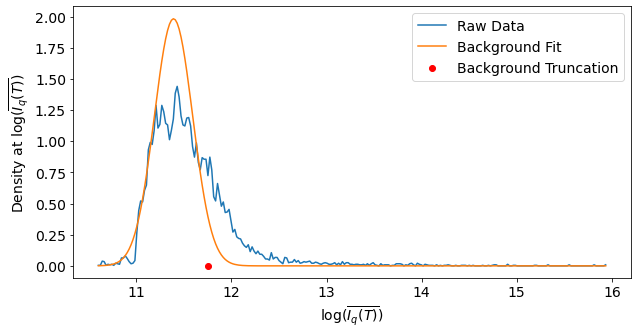

In [21]:
threshold.plot_cutoff((10,5))

In [22]:
Data_thresh     = threshold.data_thresholded  # shape=(num_temperatures, num_thresholded data)
Data_ind        = threshold.ind_thresholded           # contains hkl indices of the thresholded data.

print('num of original data pixels=', np.prod(I.shape[1:])) 
print('num of thresholded data pixels=', Data_thresh.shape[1])

num of original data pixels= 484000000
num of thresholded data pixels= 2864


In [24]:
Data_thresh.shape

(17, 2864)

In [27]:
Data_ind

array([[  0,  15],
       [  0,  16],
       [  0,  17],
       ...,
       [106,  48],
       [106,  49],
       [106,  50]])

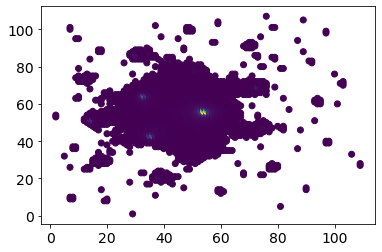

In [56]:
plt.scatter(Data_ind[:,0],Data_ind[:,1],c=Data_thresh)

# Clustering

In [163]:
Tlist=T[:drop]
x_train = np.array(Tlist)
data_post_thresh = Data_thresh
Rescaled_data  = (data_post_thresh/np.mean(data_post_thresh,axis=0)-1) 
# Rescaled_data = (data_post_thresh-np.mean(data_post_thresh,axis=0))/np.std(np.mean(data_post_thresh,axis=0)) 

y_train=Rescaled_data.transpose() 
print('Data shape: (num_data, num_T)=',y_train.shape)

Data shape: (num_data, num_T)= (583, 17)


Num per cluster [282, 301]


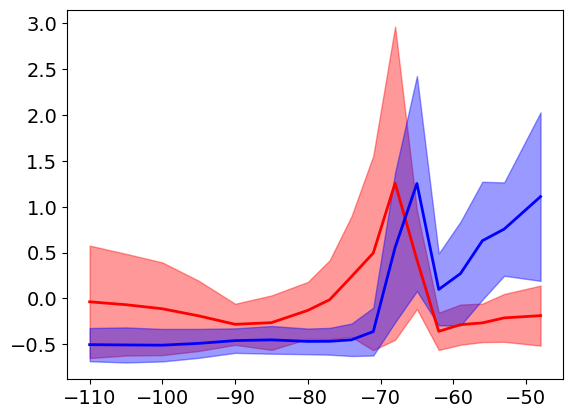

In [164]:
num_clusters = 2
clusterGMM = GMM(y_train,num_clusters)
clusterGMM.RunEM()
print('Num per cluster',clusterGMM.num_per_cluster)
cluster_assignments = clusterGMM.cluster_assignments
clusterGMM.Plot_Cluster_Results_traj(x_train)

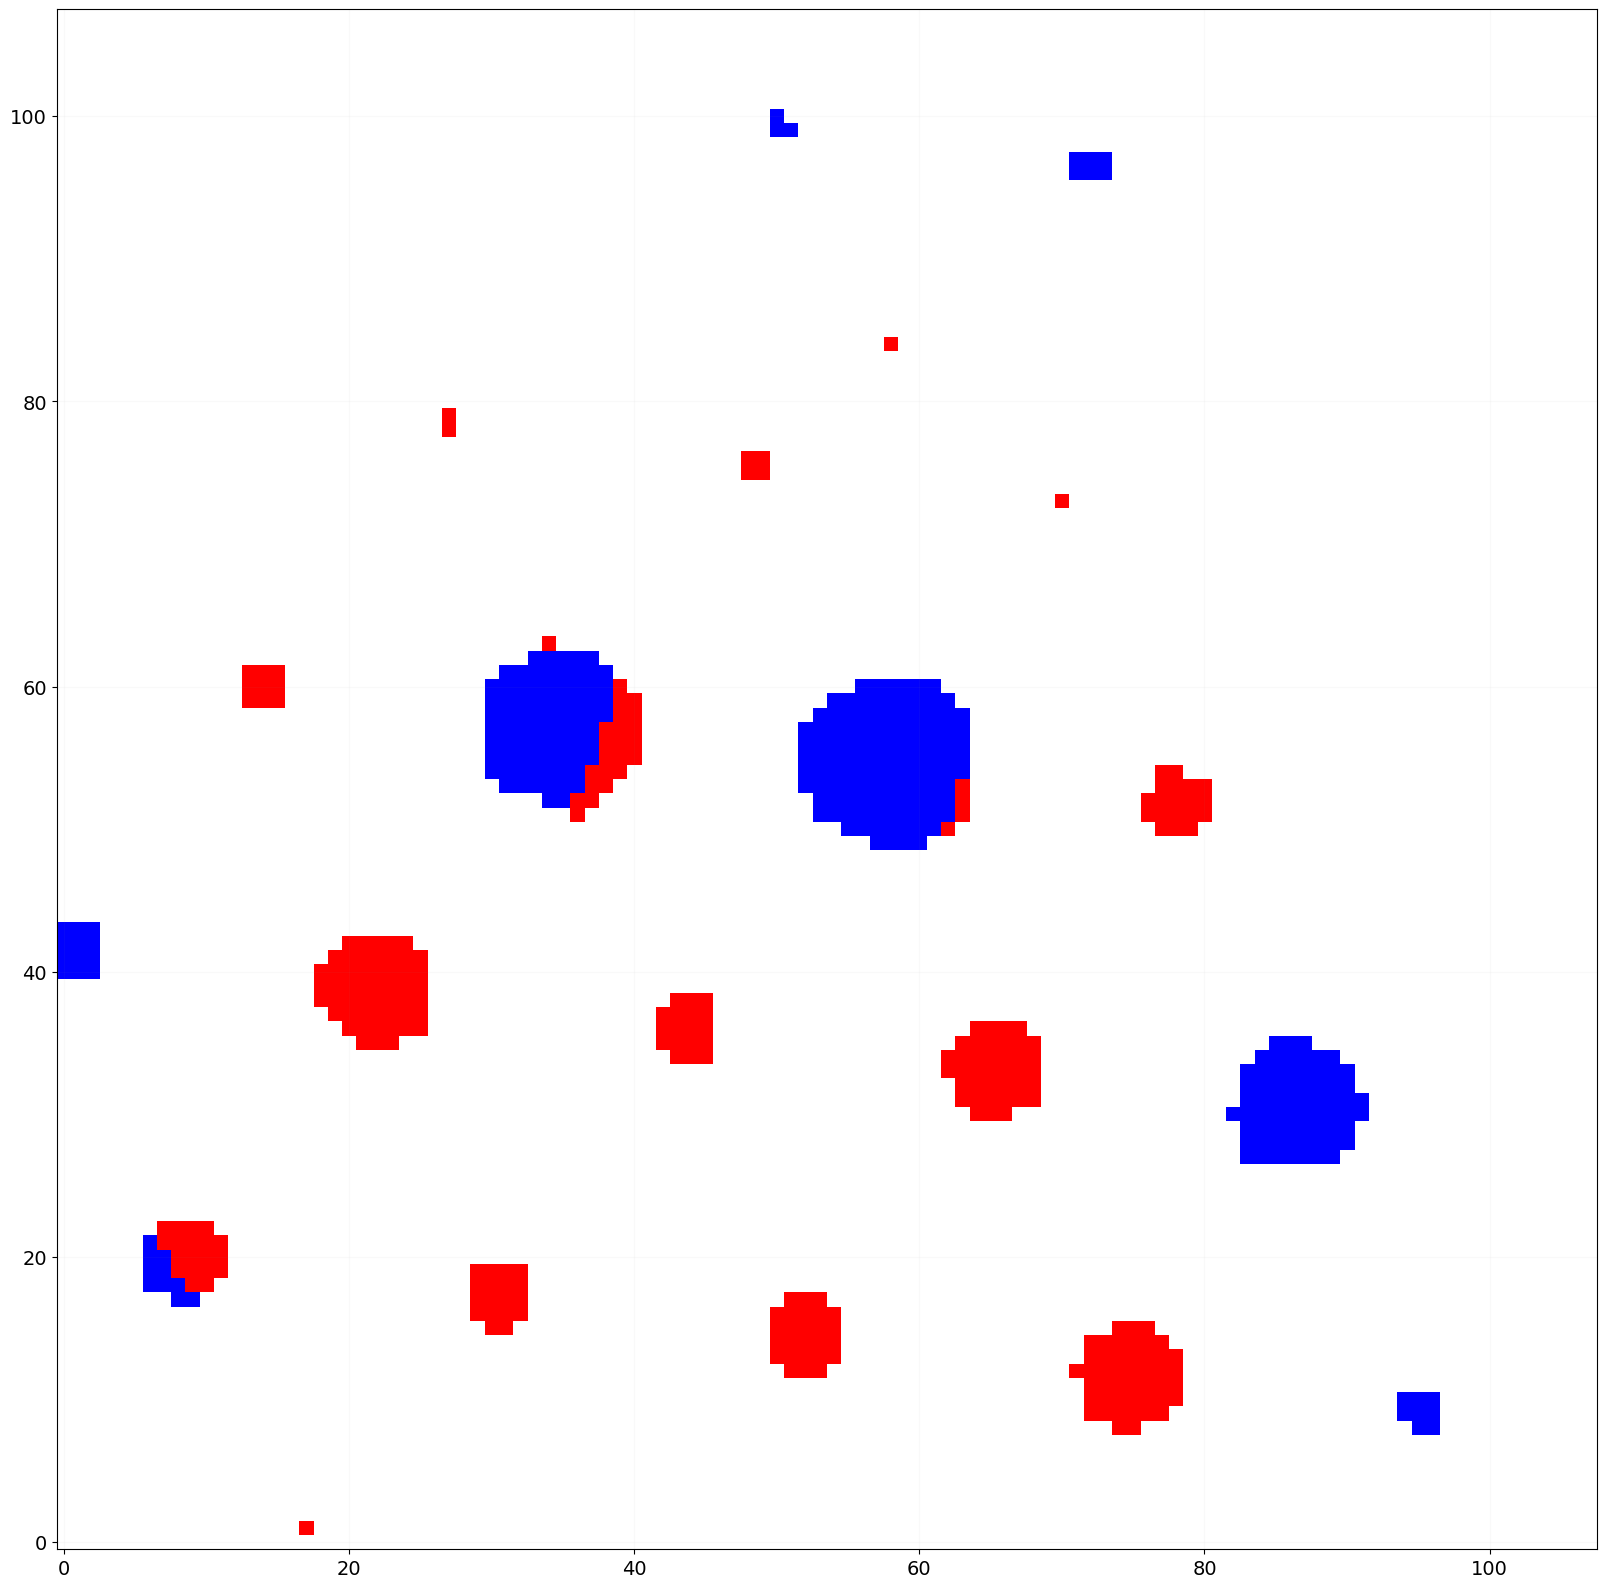

In [165]:
plotting_slice = threshold.thresholded.copy()
for k in range(num_clusters):
    cluster_mask = clusterGMM.cluster_assignments == k
    cluster_ind = Data_ind[cluster_mask]
    plotting_slice[cluster_ind[:, 0], cluster_ind[:, 1]] = k + 2
color_list = ['white', 'gainsboro', 'red', 'blue', 'green', 'purple', 'yellow', 'orange', 'pink']
cluster_cmap = colors.ListedColormap(color_list)
    
bounds = []
for i in range(len(color_list)+1):
    bounds.append(i-0.5)
norm = colors.BoundaryNorm(bounds,cluster_cmap.N)
fig=plt.figure(figsize=(20,20))


plt.imshow(plotting_slice,origin='lower',cmap=cluster_cmap,norm=norm)
plt.grid(color='#999999', linestyle='-', alpha=0.05)

In [90]:
Bad_Clusters=[0,] # Select the list clusters to be removed: 0 for Red, 1 for blue, 2 for green, 3 for violet, 4 for yellow, 5 for orange, 6 for pink clusters...
# Note that the color assignments can change with each run.


# This block removes the data belonging to the bad clusters from the first clustering  
cluster_assignments = clusterGMM.cluster_assignments 
BadC_mask           = ~np.isin(cluster_assignments, Bad_Clusters)

Good_data              = Data_thresh[:,BadC_mask] 
Good_rescaled_data     = Rescaled_data[:,BadC_mask]   # the rescaled data belonging to the good clusters
Good_ind               = Data_ind[BadC_mask]          # (h,k,l) indices of the good data

Data shape: (num_data, num_T)= (1425, 17)
Num per cluster [915, 510]


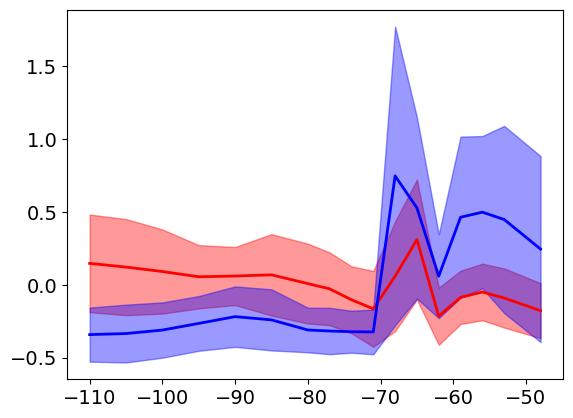

In [91]:
x_train = np.array(Tlist)


y_train=Good_rescaled_data.transpose() 

print('Data shape: (num_data, num_T)=',y_train.shape)


num_clusters = 2
clusterGMM_1 = GMM(y_train,num_clusters)
clusterGMM_1.RunEM()
print('Num per cluster',clusterGMM_1.num_per_cluster)
clusterGMM_1.Plot_Cluster_Results_traj(x_train)

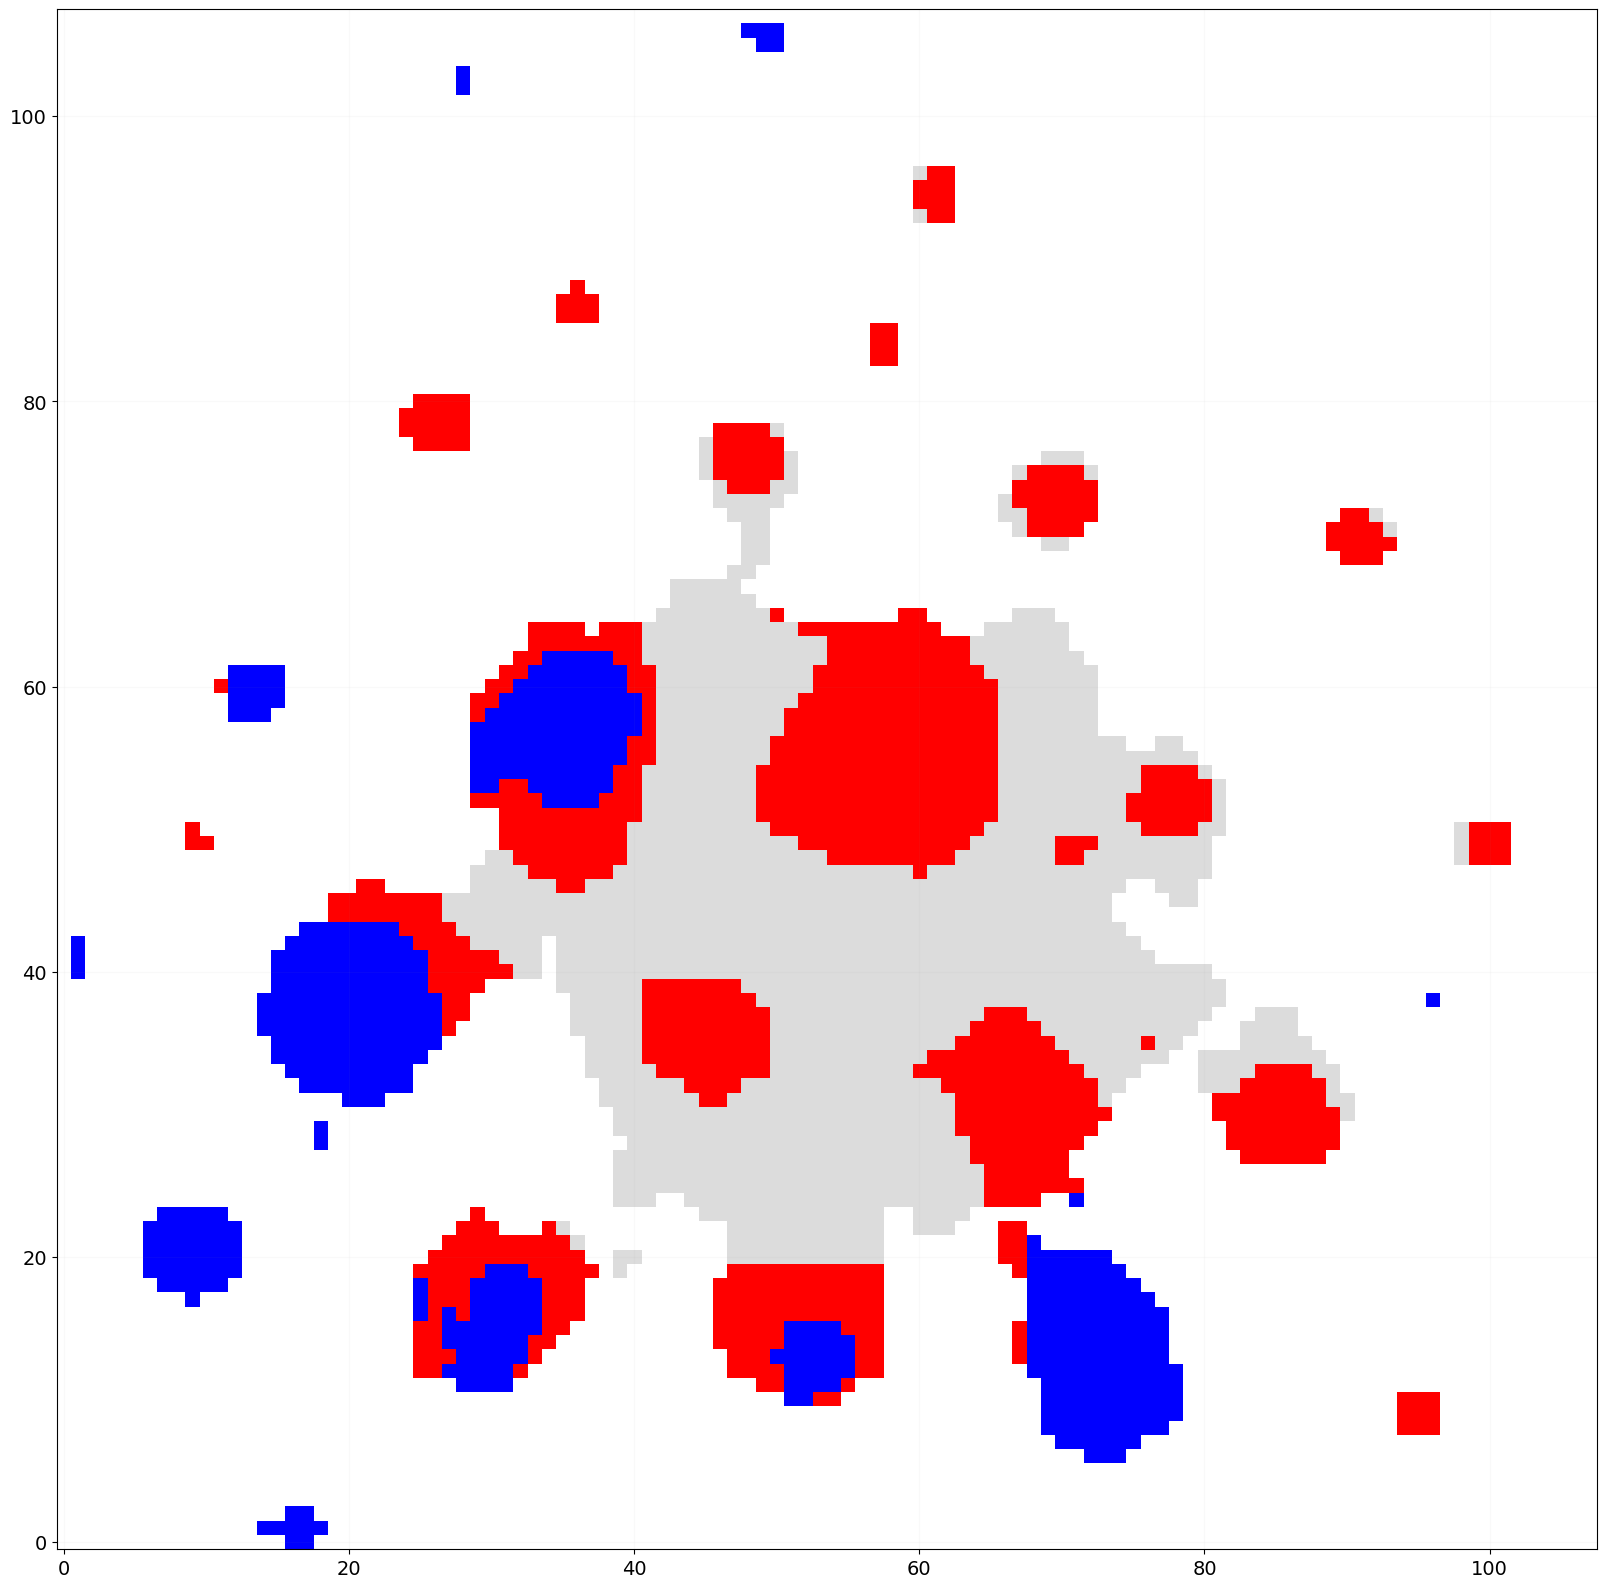

In [92]:
plotting_slice = threshold.thresholded.copy()



for k in range(num_clusters):
    cluster_mask = clusterGMM_1.cluster_assignments == k
    cluster_ind = Good_ind[cluster_mask]
    plotting_slice[cluster_ind[:, 0], cluster_ind[:, 1]] = k + 2
            
color_list = ['white', 'gainsboro', 'red', 'blue', 'green', 'purple', 'yellow', 'orange', 'pink']
cluster_cmap = colors.ListedColormap(color_list)
    
bounds = []
for i in range(len(color_list)+1):
    bounds.append(i-0.5)
norm = colors.BoundaryNorm(bounds,cluster_cmap.N)




fig=plt.figure(figsize=(20,20))


plt.imshow(plotting_slice,origin='lower',cmap=cluster_cmap,norm=norm)
plt.grid(color='#999999', linestyle='-', alpha=0.05)

    

# Draft

In [6]:
fn_list=os.listdir(workingdir)

In [7]:
def get_temp(fn):
    return int(re.search(r'.*(?=C)',fn).group(0))

In [8]:
temp_list=[get_temp(fn) for fn in fn_list]

In [9]:
temp_list_sorted,fn_list_sorted=zip(*sorted(zip(temp_list,fn_list)))

In [99]:
z2=np.load(workingdir+fn_list_sorted[-1])

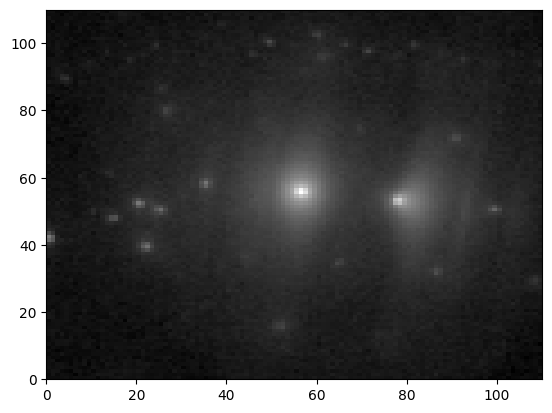

In [100]:
fig,ax=plt.subplots()
data=z2[100,100,:,:]
im=ax.pcolormesh(data,cmap='gray', norm=colors.LogNorm(vmin=data.min(), vmax=data.max()))

In [10]:
import psutil

In [11]:
psutil.Process().memory_info().rss / (1024 * 1024*1024)

0.20232772827148438

In [54]:
gc.collect()

822

In [12]:
import dask.array as da


In [13]:

data = np.arange(100_000).reshape(200, 500)
a = da.from_array(data, chunks=(100, 100))

In [14]:
a[0,0].compute()

0

In [15]:
b = a.max(axis=1)[::-1] + 10

In [16]:
import graphviz

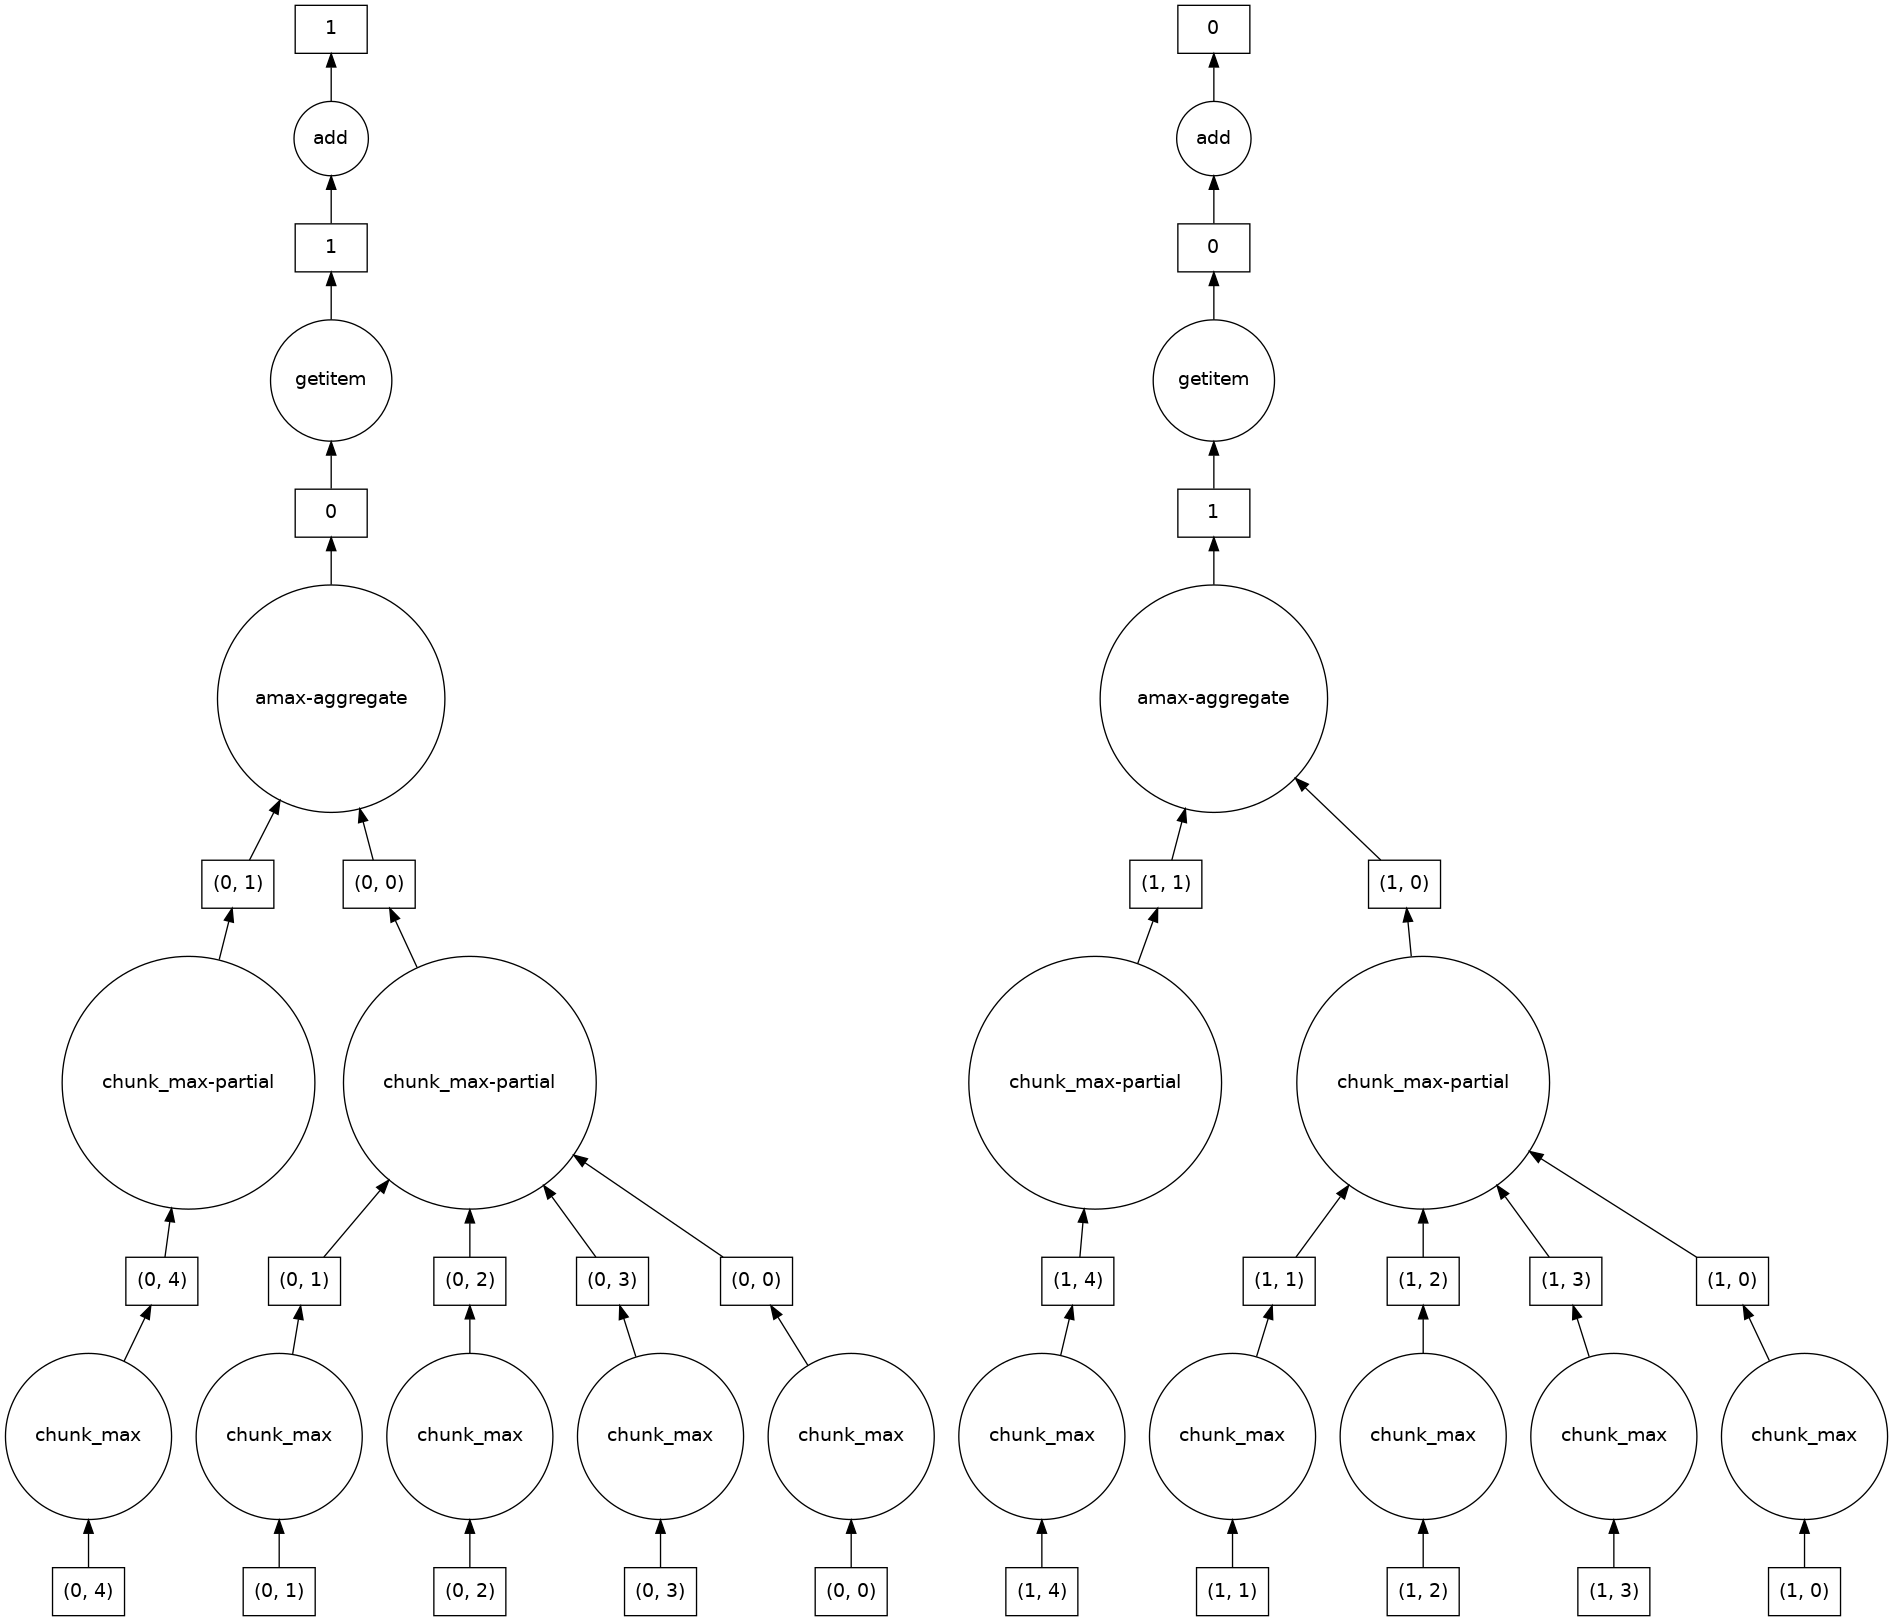

In [19]:
b.visualize()

In [20]:
x = da.ones((1000000, 1000000), chunks=(1000, 1000))

In [21]:
x

dask.array<ones_like, shape=(1000000, 1000000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [61]:
zz=dask.array.from_npy_stack(workingdir)

FileNotFoundError: [Errno 2] No such file or directory: '../STEM_recal/info'

In [34]:
d1 = np.random.random(size = (1000,20))
d2 = np.random.random(size = (1000,1000))

In [24]:
import h5py

In [37]:
hf = h5py.File('data.hdf5', 'w')

hf.create_dataset('dataset_1', data=d1, compression="gzip", compression_opts=9)
hf.create_dataset('dataset_2', data=d2, compression="gzip", compression_opts=9)

hf.close()

In [29]:
np.save('data.npy',d2)

In [38]:
hf2 = h5py.File('data.hdf5', 'r')

In [40]:
[x for x in hf2.keys()]

['dataset_1', 'dataset_2']

In [41]:
list(hf2.keys())

['dataset_1', 'dataset_2']

In [58]:
f = h5py.File('test.h5', 'w')

In [59]:
arr = f.create_dataset('T', (len(fn_list_sorted),*z2.shape), chunks=True,compression="gzip", compression_opts=9)

In [60]:
arr[0]=z2

In [61]:
f.close()

In [51]:
arr

<HDF5 dataset "T": shape (18, 200, 200, 110, 110), type "<f4">

In [ ]:
hf = h5py.File('data.hdf5', 'w')

for fn in 

In [36]:
hf2.close()

In [74]:
psutil.Process().memory_info().rss / (1024 * 1024*1024)

7.486968994140625

In [72]:
gc.collect()

0

In [67]:
del tmp

NameError: name 'tmp' is not defined

In [ ]:
I=[]
for fn in fn_list_sorted:
    print('before load {}={:.2f} GB'.format(fn,psutil.Process().memory_info().rss / (1024 * 1024*1024)))
    tmp=np.load(workingdir+fn_list_sorted[0])
    I.append(tmp[100,100])
    print('after load={:.2f}GB'.format(psutil.Process().memory_info().rss / (1024 * 1024*1024)))
    del tmp

In [58]:
def single_position(x,y):
    
    I=[]
    for fn in fn_list_sorted:
        print('before load {}={:.2f} GB'.format(fn,psutil.Process().memory_info().rss / (1024 * 1024*1024)))
        tmp=np.load(workingdir+fn_list_sorted[0])
        I.append(tmp[x,y])
        print('after load={:.2f}GB'.format(psutil.Process().memory_info().rss / (1024 * 1024*1024)))
        del tmp
    return np.array(I)

SyntaxError: no binding for nonlocal 'tmp' found (4200943759.py, line 5)

In [ ]:
I.shape

In [ ]:
fig,ax=plt.subplots()
ax.pcolor(I[0],cmap='gray', norm=colors.LogNorm(vmin=data.min(), vmax=data.max()))

In [11]:
z2.shape

(200, 200, 110, 110)

In [60]:
z2[100,100].max(),z2[100,100].min()

(25149210.0, 40827.773)

In [12]:
import matplotlib.colors as colors

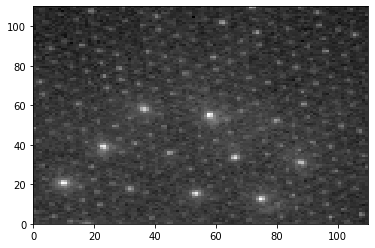

In [14]:
fig,ax=plt.subplots()
data=z2[150,150]
ax.pcolormesh(data,cmap='gray', norm=colors.LogNorm(vmin=data.min(), vmax=data.max()))

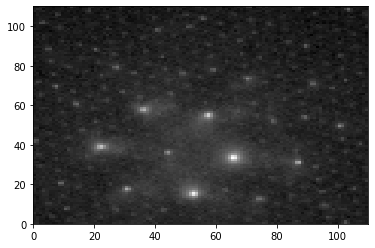

In [17]:
fig,ax=plt.subplots()
data=z2[120,120]
ax.pcolormesh(data,cmap='gray', norm=colors.LogNorm(vmin=data.min(), vmax=data.max()))

In [ ]:
from matplotlib.animation import FuncAnimation


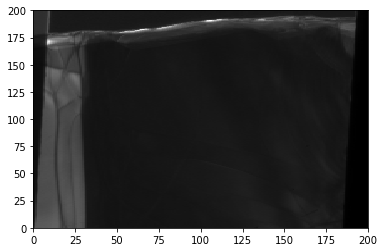

In [16]:
fig,ax=plt.subplots()
ax.pcolormesh(z2[:,:,50:60,15:25].sum(axis=(2,3)),cmap='gray')

In [44]:
z2.shape

(200, 200, 110, 110)

In [45]:
z.shape[0]

484000032